In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import pandas as pd
from pandas_summary import DataFrameSummary

In [25]:
PATH_PROCESSED='processed/'
PATH = 'dataset/'

user, occupation = [pd.read_csv(PATH + fname+'.csv', low_memory=False, sep="|") for fname in ['user', 'occupation']]
info, train = [pd.read_csv(PATH + fname+'.csv', low_memory=False, sep="\t") for fname in ['info', 'train']]
test = pd.read_csv(PATH + 'test.csv', low_memory=False, sep=",")
item = pd.read_csv(PATH + 'item.csv',  low_memory=False, encoding='latin-1', sep="|")

item.rename( columns={'movieId' :'movie_id', 'movieTitle' :'movie_title', 'release date' :'release_date', 'video release date' :'video_release_date', 'IMDb URL' :'imdb_url', 'unknown' :'unknown', 'Action' :'action', 'Adventure' :'adventure', 'Animation' :'animation', 'Children\'s' :'children', 'Comedy' :'comedy', 'Crime' :'crime', 'Documentary' :'documentary', 'Drama' :'drama', 'Fantasy' :'fantasy', 'Film-Noir' :'film-noir', 'Horror' :'horror', 'Musical' :'musical', 'Mystery' :'mystery', 'Romance' :'romance', 'Sci-Fi' :'sci-fi', 'Thriller' :'thriller', 'War' :'war', 'Western' :'western'}, inplace=True)

user.rename( columns={'user id' :'user_id', 'age' :'age', 'gender' :'gender', 'occupation' :'occupation', 'zip code' :'zip_code'}, inplace=True)

train.rename( columns={'userId' :'user_id', 'movieId' :'movie_id'}, inplace=True)
test.rename( columns={'Id' :'id', 'userId' :'user_id', 'movieId' :'movie_id'}, inplace=True)


In [26]:
u_unique = train.user_id.unique()
user2Idx = {o:i+1 for i,o in enumerate(u_unique)}

m_unique = train.movie_id.unique()
movie2Idx = {o:i+1 for i,o in enumerate(m_unique)}

In [27]:
PATH_PROCESSED = 'processed/'
joined = pd.read_feather(PATH_PROCESSED + 'joined.fth')

In [28]:
genre = ['action', 'adventure', 'animation',
         "children", 'comedy', 'crime', 'documentary', 'drama', 'fantasy',
         'film-noir', 'horror', 'musical', 'mystery', 'romance', 'sci-fi',
         'thriller', 'war', 'western']

In [29]:
print (train.shape, joined.shape)
#ratings = joined

(80000, 4) (80000, 36)


In [30]:
joined.head()

,user_id,movie_id,rating,timestamp,movie_title,release_date,unknown,action,adventure,animation,...,gender,occupation,zip_code,ReleaseYear,ReleaseMonthYear,WatchedYear,WatchedMonthYear,watchReleaseDiff,watchNow-releaseDiff,ageRange
0,1,1,5,-1.616731,Toy Story (1995),1995-01-01,0,0,0,1,...,1,19,85711,-135.559629,82,0,7,-0.501916,-0.482847,1
1,1,2,3,-1.254339,GoldenEye (1995),1995-01-01,0,1,1,0,...,1,19,85711,-135.559629,82,0,6,-0.497500,-0.482847,1
2,1,3,4,-0.944145,Four Rooms (1995),1995-01-01,0,0,0,0,...,1,19,85711,-135.559629,82,0,5,-0.493852,-0.482847,1
3,1,4,3,-1.254348,Get Shorty (1995),1995-01-01,0,1,0,0,...,1,19,85711,-135.559629,82,0,6,-0.497500,-0.482847,1
4,1,5,3,1.163327,Copycat (1995),1995-01-01,0,0,0,0,...,1,19,85711,-135.559629,82,1,4,-0.469086,-0.482847,1


In [31]:
idx2Movie = {v:k for k,v in movie2Idx.items()}

joined.user_id = joined.user_id.apply(lambda x: user2Idx[x])
joined.movie_id = joined.movie_id.apply(lambda x: movie2Idx[x])

In [32]:
joined.columns

Index(['user_id', 'movie_id', 'rating', 'timestamp', 'movie_title',
       'release_date', 'unknown', 'action', 'adventure', 'animation',
       'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy',
       'film-noir', 'horror', 'musical', 'mystery', 'romance', 'sci-fi',
       'thriller', 'war', 'western', 'age', 'gender', 'occupation', 'zip_code',
       'ReleaseYear', 'ReleaseMonthYear', 'WatchedYear', 'WatchedMonthYear',
       'watchReleaseDiff', 'watchNow-releaseDiff', 'ageRange'],
      dtype='object')

In [33]:
test_size=0.2

In [34]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_val = train_test_split(joined, test_size=test_size)

In [35]:
n_split = int(len(joined) * test_size)
ratings_train = joined[n_split:]
ratings_val = joined[:n_split]
len(ratings_train), len(ratings_val)

(64000, 16000)

In [36]:
n_users = int(user.user_id.nunique())
n_movies = int(item.movie_id.nunique())
n_gender = int(joined.gender.nunique())
n_occupation = int(joined.occupation.nunique())


n_users_train = int(ratings_train.user_id.nunique())
n_movies_train = int(ratings_train.movie_id.nunique())
print(n_users, n_users_train, n_movies, n_movies_train, n_gender, n_occupation)

943 654 1682 1612 2 21


In [37]:
max_rating = ratings_train['rating'].max()
min_rating = ratings_train['rating'].min()
av_rating = ratings_train['rating'].mean()
max_rating, min_rating, av_rating
#(5, 1, 3.524453125)

(5, 1, 3.524453125)

In [38]:
from keras.layers import Input, Embedding, Flatten, Dropout, Concatenate, Dense, Activation, Lambda
from keras import Model
from keras.regularizers import l2
from keras.optimizers import Adam

In [39]:
#! pip install mlflow

In [40]:
import mlflow.keras
mlflow.autolog()

#! mlflow ui

2022/12/31 09:48:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2022/12/31 09:48:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


In [41]:
batch_size = 64
epochs=100
learning_rate = 0.0005

In [42]:
genre_input = Input(shape=[len(genre)],name='genre')
timestamp_input = Input(shape=[1],name='timestamp')

movie_input = Input(shape=[1],name='Item')
movie_embedding = Embedding(n_movies + 1, 20, name='Movie-Embedding', embeddings_regularizer = l2(learning_rate))(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
# movie_vec = Dropout(0.2)(movie_vec)

user_input = Input(shape=[1],name='User')
user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, 8,name='User-Embedding', embeddings_regularizer = l2(learning_rate))(user_input))
# user_vec = Dropout(0.2)(user_vec)

gender_input = Input(shape=[1],name='gender')
gender_vec = Flatten(name='FlattenGender')(Embedding(n_gender, 1,name='Gender-Embedding', embeddings_regularizer = l2(learning_rate))(gender_input))

age_input = Input(shape=[1],name='age')
age_vec = Flatten(name='FlattenAge')(Embedding(int(joined.ageRange.nunique()), 3,name='Age-Embedding', embeddings_regularizer = l2(learning_rate))(age_input))

occupation_input = Input(shape=[1],name='occupation')
occupation_vec = Flatten(name='FlattenOccupation')(Embedding(n_occupation, 3,name='Occupation-Embedding', embeddings_regularizer = l2(learning_rate))(occupation_input))

watched_input = Input(shape=[1],name='watchReleaseDiff')

release_year_input = Input(shape=[1],name='ReleaseYear')
#release_year_vec = Flatten(name='ReleaseYear')(Embedding(int(ratings.ReleaseYear.nunique()), 1,name='ReleaseYear-Embedding', embeddings_regularizer = l2(learning_rate))(release_year_input))

concat_nodes = [movie_vec, user_vec, timestamp_input, genre_input]
concat_nodes += [gender_vec, occupation_vec, watched_input, age_vec, release_year_input]

concat = Concatenate(name='Concat')(concat_nodes)
concat = Dropout(0.2)(concat)

x = Dense(50,name='FullyConnected-1', activation='relu', kernel_regularizer=l2(learning_rate))(concat)
x = Dropout(0.5)(x)
x = Dense(50,name='FullyConnected-2', activation='relu')(x)
x = Dropout(0.5)(x)



## Se pueden sacar las siguientes dos lineas para no forzar a sigmoidea
x = Dense(1, activation='sigmoid',name='Activation')(x)
x = Lambda(lambda z: (max_rating - min_rating) * z + min_rating)(x)
##


input_nodes = [user_input, movie_input, timestamp_input, genre_input]
input_nodes += [gender_input, occupation_input, watched_input, age_input, release_year_input]

inputs_train = [ratings_train.user_id, ratings_train.movie_id, ratings_train.timestamp, ratings_train[genre],
                ratings_train.gender, ratings_train.occupation, ratings_train.watchReleaseDiff, ratings_train.ageRange, ratings_train.ReleaseYear]

inputs_val = [ratings_val.user_id, ratings_val.movie_id, ratings_val.timestamp, ratings_val[genre],
              ratings_val.gender, ratings_val.occupation, ratings_val.watchReleaseDiff, ratings_val.ageRange, ratings_val.ReleaseYear]

model = Model(input_nodes, x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Item (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 User (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 gender (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 occupation (InputLayer)        [(None, 1)]          0           []                               
                                                                                            

In [43]:
from fnn_helper import PlotLosses
plot_losses = PlotLosses(1, None)

In [44]:
import keras.backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [45]:
adam = Adam(learning_rate=learning_rate)
model.compile(optimizer=adam,loss= 'mean_squared_error', metrics=[root_mean_squared_error])

In [46]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath=PATH_PROCESSED + 'fv_weights.hdf5', verbose=1, save_best_only=True, monitor='val_root_mean_squared_error')

In [47]:
ratings_train.timestamp[79999]
ratings_train.ReleaseYear[79999]
#numpy.int64

-135.63019770097566

In [48]:
# Verify input values
for i in range(len(inputs_train)):
    print(i, type(inputs_train[i]), len(inputs_train[i]), type(inputs_train[i].iloc[0]), inputs_train[i].iloc[0])

0 <class 'pandas.core.series.Series'> 64000 <class 'numpy.int64'> 290
1 <class 'pandas.core.series.Series'> 64000 <class 'numpy.int64'> 135
2 <class 'pandas.core.series.Series'> 64000 <class 'numpy.float64'> -0.5811537671890522
3 <class 'pandas.core.frame.DataFrame'> 64000 <class 'pandas.core.series.Series'> action         1
adventure      1
animation      0
children       0
comedy         0
crime          0
documentary    0
drama          0
fantasy        0
film-noir      0
horror         0
musical        0
mystery        0
romance        0
sci-fi         1
thriller       0
war            1
western        0
Name: 16000, dtype: int64
4 <class 'pandas.core.series.Series'> 64000 <class 'numpy.int64'> 1
5 <class 'pandas.core.series.Series'> 64000 <class 'numpy.int64'> 4
6 <class 'pandas.core.series.Series'> 64000 <class 'numpy.float64'> -0.6299736928734406
7 <class 'pandas.core.series.Series'> 64000 <class 'numpy.int64'> 2
8 <class 'pandas.core.series.Series'> 64000 <class 'numpy.float64'

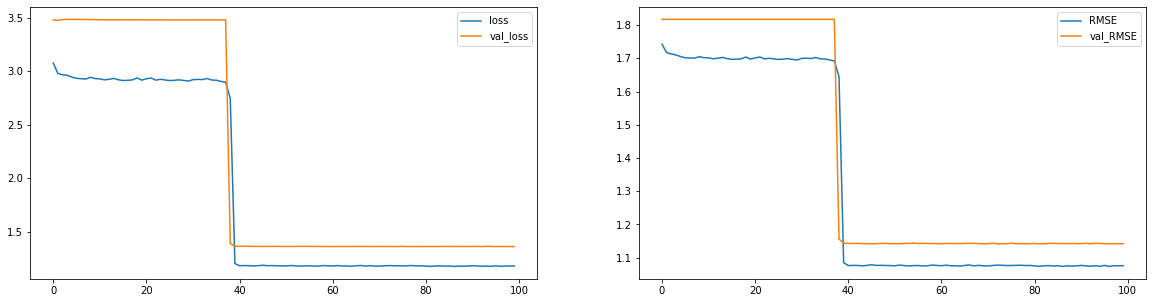


Epoch 100: val_root_mean_squared_error did not improve from 1.14160
1000/1000 - 2s - loss: 1.1781 - root_mean_squared_error: 1.0757 - val_loss: 1.3600 - val_root_mean_squared_error: 1.1422 - 2s/epoch - 2ms/step


2022/12/31 09:52:38 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'list'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)


INFO:tensorflow:Assets written to: /var/folders/46/12xscy9x3r74df50b6lw_rvr0000gn/T/tmpl28nf4oo/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/46/12xscy9x3r74df50b6lw_rvr0000gn/T/tmpl28nf4oo/model/data/model/assets
2022/12/31 09:52:50 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/46/12xscy9x3r74df50b6lw_rvr0000gn/T/tmpl28nf4oo/model, flavor: tensorflow), fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback.


CPU times: user 6min, sys: 1min 22s, total: 7min 22s
Wall time: 4min 8s


In [49]:
%%time

history = model.fit(inputs_train,
                    ratings_train.rating,
                    validation_data=(inputs_val,
                       ratings_val.rating),
                    batch_size = batch_size,
                    callbacks = [plot_losses, checkpointer],
                    epochs=epochs, verbose=2)

In [50]:
model.save(PATH_PROCESSED + 'fv_model.h5')

In [51]:
model.evaluate(inputs_val, ratings_val.rating)

500/500 [==============================] - 1s 2ms/step - loss: 1.3600 - root_mean_squared_error: 1.1356


[1.3600239753723145, 1.135568618774414]

In [52]:
model.load_weights(PATH_PROCESSED + 'fv_weights.hdf5')

In [53]:
loss, acc = model.evaluate(inputs_val, ratings_val.rating)
print(loss, acc)

500/500 [==============================] - 1s 2ms/step - loss: 1.3598 - root_mean_squared_error: 1.1349
1.3598155975341797 1.1348590850830078


# Embeddings

In [54]:
movie_embeddings_layer = model.layers[5]
user_embeddings_layer = model.layers[6]
movie_embeddings_layer.name, user_embeddings_layer.name

('Movie-Embedding', 'User-Embedding')

In [55]:
movie_embeddings_matrix = movie_embeddings_layer.get_weights()[0]
user_embeddings_matrix = user_embeddings_layer.get_weights()[0]
movie_embeddings_matrix.shape, user_embeddings_matrix.shape

((1683, 20), (944, 8))

In [56]:
model_test_emb = Model([movie_input], [movie_embedding])

In [57]:
index = 424 #6
movie_embed = model_test_emb.predict([index])
item.loc[idx2Movie[index]].movie_title

1/1 [==============================] - 0s 86ms/step


'Spellbound (1945)'

In [58]:
from sklearn.neighbors import NearestNeighbors

In [59]:
nbrs = NearestNeighbors(n_neighbors=10, metric='cosine').fit(movie_embeddings_matrix)

2022/12/31 09:52:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8ea3aee033584f58a4560ee5595d222d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/12/31 09:52:54 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2022/12/31 09:52:54 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2022/12/31 09:52:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [60]:
neighbors = nbrs.kneighbors([movie_embeddings_matrix[index]])

In [61]:
neighbors

(array([[5.9604645e-08, 2.6663065e-02, 3.1450927e-02, 3.2612860e-02,
         3.6220193e-02, 3.6389112e-02, 4.1541219e-02, 4.2056262e-02,
         4.2098701e-02, 4.3205321e-02]], dtype=float32),
 array([[ 424,  112,  174, 1284, 1567,   87,  746,   47,  347,   37]]))

In [62]:
for idx in neighbors[1][0]:
    print(item.loc[idx2Movie[idx]].movie_title)

Spellbound (1945)
Bram Stoker's Dracula (1992)
Mother (1996)
Mighty, The (1998)
Hush (1998)
Manon of the Spring (Manon des sources) (1986)
Twelve Monkeys (1995)
Robert A. Heinlein's The Puppet Masters (1994)
Return of the Jedi (1983)
Quiz Show (1994)


In [63]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

date and time = 31/12/2022 09:52:59
